In [71]:
import pandas as pd
import gensim
from sklearn.linear_model import LinearRegression
import numpy as np
import string
import matplotlib.pyplot as plt
import matplotlib

In [48]:
df = pd.read_csv('anew2017_data.csv', usecols = [0,2,3,4,5,6,7])
rating_matrix = df.iloc[:,[0,1,3,5]].set_index('word').T.to_dict(orient='list')
df.head()

,word,valence,valence_sd,arousal,arousal_sd,dominance,dominance_sd
0,abandon,2.36,1.65,4.66,2.61,3.45,2.44
1,abduction,2.76,2.06,5.53,2.43,3.49,2.38
2,able,6.74,2.00,4.30,2.17,6.83,2.04
3,abortion,3.50,2.30,5.39,2.80,4.59,2.54
4,abrupt,4.22,1.50,4.95,2.16,4.78,1.88


In [21]:
text1 = """Imprisoning someone for asserting what today qualifies as common knowledge might seem extreme, 
but metamorphosis - the process through which some animals abruptly transform their bodies after birth - has long 
inspired misunderstanding and mysticism. People have known since at least the time of ancient Egypt that worms 
and grubs develop into adult insects, but the evolution of insect metamorphosis remains a genuine biological 
mystery even today. Some scientists have proposed outlandish origin tales, such as Donald Williamson's idea that 
butterfly metamorphosis resulted from an ancient and accidental mating between two different species—one that 
wriggled along ground and one that flitted through the air.""".lower()

translator = str.maketrans('', '', string.punctuation+'\n')
text_words = list(filter(lambda x: len(x)>1, text1.translate(translator).split(' ')))

In [22]:
wv_model = gensim.models.KeyedVectors.load_word2vec_format('./GoogleNews-vectors-negative300.bin', binary=True, limit=999900)

In [23]:
wvec_words = set(wv_model.vocab.keys())
senti_words = set(rating_matrix.keys())
common_words = wvec_words.intersection(senti_words)
len(common_words), len(wvec_words), len(senti_words)

(3181, 999900, 3188)

In [39]:
dataX = [wv_model[word] for word in common_words]
dataY = [rating_matrix[word] for word in common_words]
dataX = np.array(dataX)
dataY = np.array(dataY)
dataY.shape, dataX.shape

((3181, 3), (3181, 300))

In [40]:
regrModel= LinearRegression()
regrModel.fit(dataX,dataY)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [73]:
ratings_anew = []
ratings_predicted = []

for tword in text_words:
    if tword in wvec_words:
        test_x = wv_model[tword].reshape(1,-1)

        pred_y = regrModel.predict(test_x)
        ratings_predicted.append(list(pred_y[0]))

        if tword in rating_matrix:
            ratings_anew.append(rating_matrix[tword])
        else:
            ratings_anew.append([-1,-1,-1])
            
ratings_anew = np.array(ratings_anew)
ratings_predicted = np.array(ratings_predicted)

In [85]:
matplotlib.rcParams['figure.figsize'] = 26,10

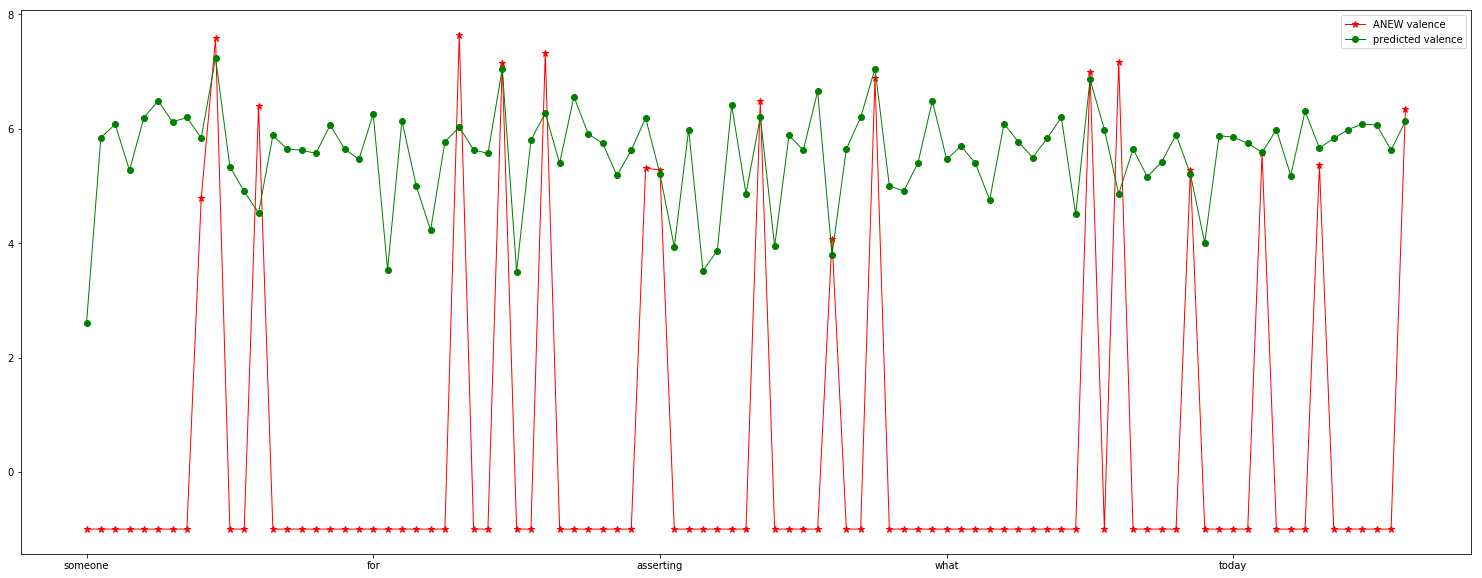

In [89]:
fig, ax = plt.subplots()

ax.plot(ratings_anew[:,0], label='ANEW valence', lw=1, markersize = 7, marker = '*', color='red')
ax.plot(ratings_predicted[:,0], label='predicted valence', lw=1, markersize = 6, marker = 'o', color='green')

ax.set_xticklabels(text_words)

plt.legend()
plt.show()

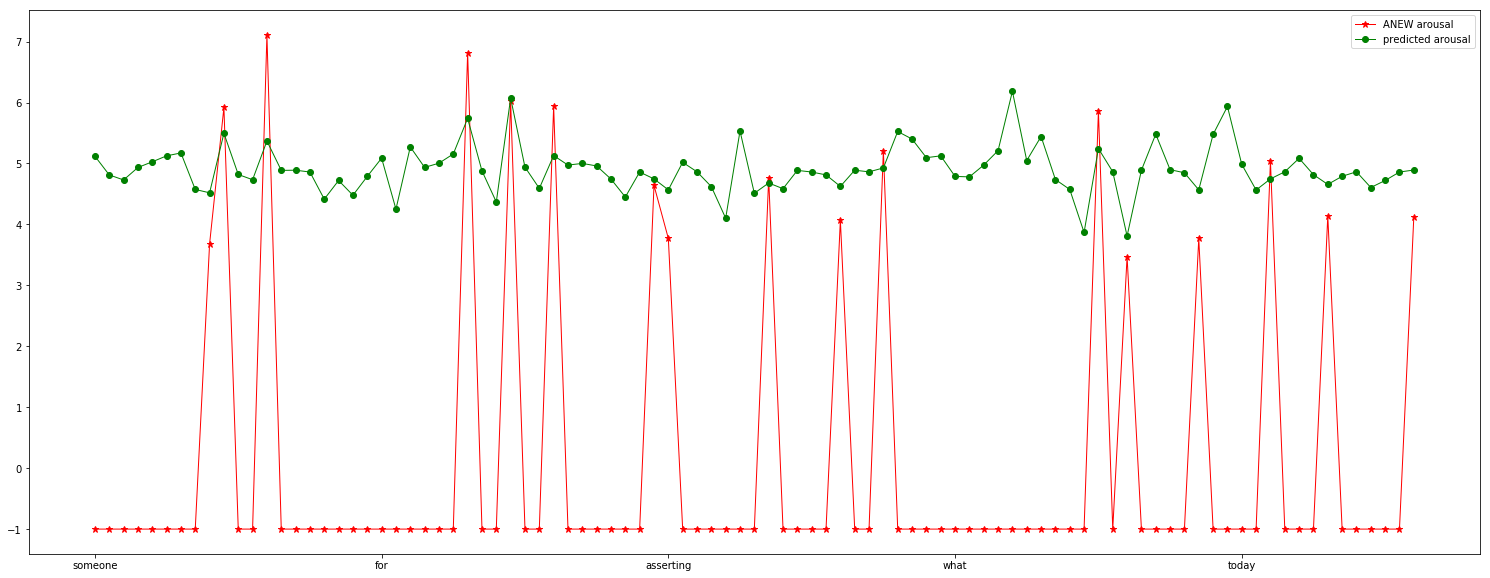

In [90]:
fig, ax = plt.subplots()

ax.plot(ratings_anew[:,1], label='ANEW arousal', lw=1, markersize = 7, marker = '*', color='red')
ax.plot(ratings_predicted[:,1], label='predicted arousal', lw=1, markersize = 6, marker = 'o', color='green')

ax.set_xticklabels(text_words)

plt.legend()
plt.show()